# Read the dataset and split training and testing set

In [1]:
import pandas as pd

data = pd.read_csv('tweet_dataset.csv')

In [2]:
data = data[['text', 'new_sentiment']].dropna()

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31329 entries, 1 to 39999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           31329 non-null  object
 1   new_sentiment  31329 non-null  object
dtypes: object(2)
memory usage: 734.3+ KB


In [4]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import re
import numpy as np
import pandas as pd
import os, json
import torch
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
import torch

if torch.cuda.is_available():    

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## BERT pretraining model
BERT (Pre-training of Deep Bidirectional Transformers for Language Understanding) introduced the method of pre-training language representations on a large text corpus and then using that model for downstream NLP tasks.

I will build a model to pretrain BERT on the masked language modeling task and next sentence prediction task.

Build a BertPretrainer model wrapping BertEncoder
The nlp.networks.BertEncoder class implements the Transformer-based encoder as described in BERT paper. It includes the embedding lookups and transformer layers (nlp.layers.TransformerEncoderBlock), but not the masked language model or classification task networks.

The nlp.models.BertPretrainer class allows a user to pass in a transformer stack, and instantiates the masked language model and classification networks that are used to create the training objectives.

## Import the BERT tokenizer

In [7]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [8]:
print(tokenizer.tokenize("Hello. This is a sample statement for visualisation purposes"))

['hello', '.', 'this', 'is', 'a', 'sample', 'statement', 'for', 'visual', '##isation', 'purposes']


In [9]:
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize("Hello. This is a sample statement for visualisation purposes")))

[7592, 1012, 2023, 2003, 1037, 7099, 4861, 2005, 5107, 6648, 5682]


In [10]:
data['new_sentiment'] = data['new_sentiment'].replace(['negative', 'neutral', 'positive'], [0, 1, 2])

In [11]:
data.head()

,text,new_sentiment
1,Layin n bed with a headache ughhhh...waitin o...,0
2,Funeral ceremony...gloomy friday...,0
3,wants to hang out with friends SOON!,2
4,We want to trade with someone who has Houston...,1
5,Re-pinging : why didn`t you go to prom? BC my ...,0


## Pre-processing the data

In [12]:
max_len = 0


for tweet in data['text']:
    
    # The following code is used to clean the tweets by removing URLs, accounts, quotation marks,etc
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    tweet = url_pattern.sub(r'', tweet)
    tweet = re.sub('\S*@\S*\s?', '', tweet)
    tweet = re.sub('\s+', ' ', tweet)
    tweet = re.sub("\'", "", tweet)

    input_ids = tokenizer.encode(tweet, add_special_tokens=True)

    max_len = max(max_len, len(input_ids))        #maximum length of input ids

print('Max sequence length: ', max_len)

Max sequence length:  110


In [13]:
input_ids = []
attention_masks = []

for sent in data['text']:
    
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, 
                        max_length = 110,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )
     
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])


input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(data['new_sentiment'].tolist())

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [14]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)  #storing the input ids,masks and labels in dataset

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])  #90-10 train-val split

In [15]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset),     #random sampling in training
            batch_size = batch_size 
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset),    #sequential sampling in validation
            batch_size = batch_size 
        )

In [16]:
from transformers import BertForSequenceClassification, AdamW, BertConfig


model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 3,   
    output_attentions = False,
    output_hidden_states = False,
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [17]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8
                )

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
from transformers import get_linear_schedule_with_warmup

epochs = 4


total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [19]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [20]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [21]:
import random
import numpy as np


seed_val = 55
epochs=1

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model.to(device)


training_stats = []

total_t0 = time.time()

y_pred = []
y_true =[]

for epoch_i in range(0, epochs):
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0
    total_train_accuracy = 0
    model.train()
    train_accuracy = []
    for step, batch in enumerate(train_dataloader):
        
        # Printing the progress after every 40 epochs
        if step % 40 == 0 and not step == 0:
            
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        logits = logits.detach().cpu().numpy()
        
        label_ids = b_labels.to('cpu').numpy()

        train_accuracy.append(flat_accuracy(logits, label_ids))
        total_train_accuracy += flat_accuracy(logits, label_ids)
        
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    print("Train Accuracy: {0:.2f}".format(avg_train_accuracy))

    avg_train_loss = total_train_loss / len(train_dataloader)            

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    val_accuracy=[]
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        

            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        output = np.argmax(logits, axis=1).flatten()
        y_pred.extend(output) # Save Prediction


        label_ids = b_labels.to('cpu').numpy()
        y_true.extend(label_ids)
        val_accuracy.append(flat_accuracy(logits, label_ids))
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Accur.':avg_train_accuracy,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 1 ========
Training...
  Batch    40  of    882.    Elapsed: 0:00:22.
  Batch    80  of    882.    Elapsed: 0:00:44.
  Batch   120  of    882.    Elapsed: 0:01:07.
  Batch   160  of    882.    Elapsed: 0:01:29.
  Batch   200  of    882.    Elapsed: 0:01:51.
  Batch   240  of    882.    Elapsed: 0:02:14.
  Batch   280  of    882.    Elapsed: 0:02:36.
  Batch   320  of    882.    Elapsed: 0:02:58.
  Batch   360  of    882.    Elapsed: 0:03:20.
  Batch   400  of    882.    Elapsed: 0:03:43.
  Batch   440  of    882.    Elapsed: 0:04:05.
  Batch   480  of    882.    Elapsed: 0:04:27.
  Batch   520  of    882.    Elapsed: 0:04:50.
  Batch   560  of    882.    Elapsed: 0:05:12.
  Batch   600  of    882.    Elapsed: 0:05:34.
  Batch   640  of    882.    Elapsed: 0:05:57.
  Batch   680  of    882.    Elapsed: 0:06:19.
  Batch   720  of    882.    Elapsed: 0:06:41.
  Batch   760  of    882.    Elapsed: 0:07:03.
  Batch   800  of    882.    Elapsed: 0:07:26.
  Batch   840  of

In [22]:
training_stats

[{'epoch': 1,
  'Training Accur.': 0.7499291383219955,
  'Training Loss': 0.592597852488494,
  'Valid. Loss': 0.47734169418714484,
  'Valid. Accur.': 0.8053527445460943,
  'Training Time': '0:08:11',
  'Validation Time': '0:00:19'}]

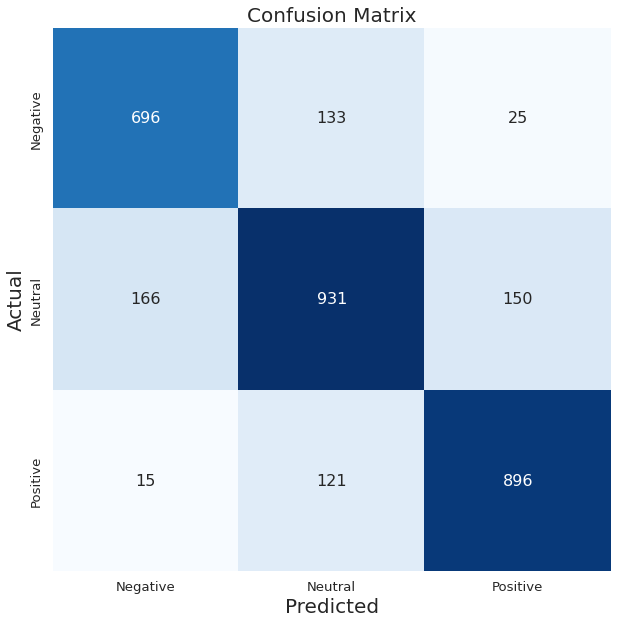

In [44]:
from matplotlib import pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix 

CLASS_LABELS  = ['Negative', 'Neutral', 'Positive']
cm_data = confusion_matrix(y_true , y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (10,10))
plt.title('Confusion Matrix', fontsize = 20)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [26]:
torch.save(model.state_dict(), 'checkpoint.pth')

In [45]:
df_vax = pd.read_csv('vaccination_all_tweets.csv')
df_vax=df_vax.dropna()
df_vax

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
6,1337851215875608579,Gunther Fehlinger,"Austria, Ukraine and Kosovo",End North Stream 2 now - the pipeline of corru...,2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12 20:06:00,it is a bit sad to claim the fame for success ...,['vaccination'],Twitter Web App,0,4,False
9,1337842295857623042,Ch.Amjad Ali,Islamabad,#ProudPakistani #LovePakArmy #PMIK @insafiansp...,2012-11-12 04:18:12,671,2368,20469,False,2020-12-12 19:30:33,#CovidVaccine \n\nStates will start getting #C...,"['CovidVaccine', 'COVID19Vaccine', 'US', 'paku...",Twitter Web App,0,0,False
10,1337841934170255365,Tamer Yazar,Turkey-Israel,"Im Market Analyst, also Editor... working (fre...",2009-09-17 16:45:16,1302,78,339,False,2020-12-12 19:29:07,"while deaths are closing in on the 300,000 mar...","['PfizerBioNTech', 'Vaccine']",Twitter Web App,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228202,1460170772299665408,VaxBLR,"Bengaluru, India",Hourly updates on FREE and PAID 18+ and 45+ va...,2021-06-21 08:44:34,31,0,0,False,2021-11-15 09:00:15,45+ #URBAN #Bengaluru #CovidVaccine Availabili...,"['URBAN', 'Bengaluru', 'CovidVaccine', 'COVISH...",VaxBlr,0,0,False
228203,1460163268262051841,VaxBLR,"Bengaluru, India",Hourly updates on FREE and PAID 18+ and 45+ va...,2021-06-21 08:44:34,31,0,0,False,2021-11-15 08:30:26,18-44 #BBMP #Bengaluru #CovidVaccine Availabil...,"['BBMP', 'Bengaluru', 'CovidVaccine', 'COVISHI...",VaxBlr,0,1,False
228204,1460163224221851655,VaxBLR,"Bengaluru, India",Hourly updates on FREE and PAID 18+ and 45+ va...,2021-06-21 08:44:34,31,0,0,False,2021-11-15 08:30:15,18-44 #URBAN #Bengaluru #CovidVaccine Availabi...,"['URBAN', 'Bengaluru', 'CovidVaccine', 'COVISH...",VaxBlr,0,0,False
228205,1460156376995573765,Gatti Valentino🐾,Southern Africa,"Entrepreneur, self taught cook🍲🌮 @Chelsea @Fer...",2019-08-28 10:31:43,8103,3113,45726,False,2021-11-15 08:03:03,They promote their Vaccines leaving out the st...,['SputnikV'],Twitter for Android,0,0,False


In [46]:
df_vax.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116057 entries, 0 to 228206
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                116057 non-null  int64 
 1   user_name         116057 non-null  object
 2   user_location     116057 non-null  object
 3   user_description  116057 non-null  object
 4   user_created      116057 non-null  object
 5   user_followers    116057 non-null  int64 
 6   user_friends      116057 non-null  int64 
 7   user_favourites   116057 non-null  int64 
 8   user_verified     116057 non-null  bool  
 9   date              116057 non-null  object
 10  text              116057 non-null  object
 11  hashtags          116057 non-null  object
 12  source            116057 non-null  object
 13  retweets          116057 non-null  int64 
 14  favorites         116057 non-null  int64 
 15  is_retweet        116057 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory

In [49]:
vax_tweets= df_vax['text']

In [50]:
input_ids = []
attention_masks = []

for tweet in vax_tweets:
    
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    tweet = url_pattern.sub(r'', tweet)
    tweet = re.sub('\S*@\S*\s?', '', tweet)
    tweet = re.sub('\s+', ' ', tweet)
    tweet = re.sub("\'", "", tweet)
    
    encoded_dict = tokenizer.encode_plus(
                        tweet,                      
                        add_special_tokens = True, 
                        max_length = 110,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )
     
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])


input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [51]:
vax_dataset= TensorDataset(input_ids, attention_masks)

batch_size = 32

vax_dataloader = DataLoader(
            vax_dataset,  
            sampler = SequentialSampler(vax_tweets),     #Sequential Sampling
            batch_size = batch_size 
        )

In [52]:
print('Predicting labels for {:,} vaccine tweets...'.format(len(input_ids)))

model.eval()

predictions = []

for batch in vax_dataloader:
 
  batch = tuple(t.to(device) for t in batch)
  
  b_input_ids, b_input_mask = batch

  with torch.no_grad():

      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  logits = logits.detach().cpu().numpy()
  
  logits=np.argmax(logits,axis=1)
  for i in range(len(logits)):
    predictions.append(logits[i])
    

print('    DONE.')

Predicting labels for 116,057 vaccine tweets...
    DONE.


In [56]:
df_vax['Sentiment'] = predictions
vax= df_vax.drop(['user_name','user_description','user_created','user_followers','user_friends','user_favourites','source','is_retweet'],axis=1)
vax.head()

,id,user_location,user_verified,date,text,hashtags,retweets,favorites,Sentiment
0,1340539111971516416,"La Crescenta-Montrose, CA",False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],0,0,1
2,1337858199140118533,Your Bed,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",0,0,1
6,1337851215875608579,"Austria, Ukraine and Kosovo",False,2020-12-12 20:06:00,it is a bit sad to claim the fame for success ...,['vaccination'],0,4,0
9,1337842295857623042,Islamabad,False,2020-12-12 19:30:33,#CovidVaccine \n\nStates will start getting #C...,"['CovidVaccine', 'COVID19Vaccine', 'US', 'paku...",0,0,1
10,1337841934170255365,Turkey-Israel,False,2020-12-12 19:29:07,"while deaths are closing in on the 300,000 mar...","['PfizerBioNTech', 'Vaccine']",0,0,0


In [57]:
vax['Sentiment']=vax['Sentiment'].map({0:'negative',1:'neutral',2:'positive'})

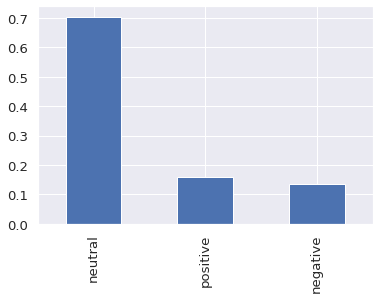

In [58]:
vax['Sentiment'].value_counts(normalize=True).plot.bar()

In [59]:
vax['date'] = pd.to_datetime(vax['date'], errors='coerce').dt.date
vax['Sentiment'] = vax['Sentiment'].map({'negative':-1,'neutral':0,'positive':1})

In [60]:
vax

,id,user_location,user_verified,date,text,hashtags,retweets,favorites,Sentiment
0,1340539111971516416,"La Crescenta-Montrose, CA",False,2020-12-20,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],0,0,0
2,1337858199140118533,Your Bed,False,2020-12-12,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",0,0,0
6,1337851215875608579,"Austria, Ukraine and Kosovo",False,2020-12-12,it is a bit sad to claim the fame for success ...,['vaccination'],0,4,-1
9,1337842295857623042,Islamabad,False,2020-12-12,#CovidVaccine \n\nStates will start getting #C...,"['CovidVaccine', 'COVID19Vaccine', 'US', 'paku...",0,0,0
10,1337841934170255365,Turkey-Israel,False,2020-12-12,"while deaths are closing in on the 300,000 mar...","['PfizerBioNTech', 'Vaccine']",0,0,-1
...,...,...,...,...,...,...,...,...,...
228202,1460170772299665408,"Bengaluru, India",False,2021-11-15,45+ #URBAN #Bengaluru #CovidVaccine Availabili...,"['URBAN', 'Bengaluru', 'CovidVaccine', 'COVISH...",0,0,0
228203,1460163268262051841,"Bengaluru, India",False,2021-11-15,18-44 #BBMP #Bengaluru #CovidVaccine Availabil...,"['BBMP', 'Bengaluru', 'CovidVaccine', 'COVISHI...",0,1,0
228204,1460163224221851655,"Bengaluru, India",False,2021-11-15,18-44 #URBAN #Bengaluru #CovidVaccine Availabi...,"['URBAN', 'Bengaluru', 'CovidVaccine', 'COVISH...",0,0,0
228205,1460156376995573765,Southern Africa,False,2021-11-15,They promote their Vaccines leaving out the st...,['SputnikV'],0,0,0


In [61]:
vax.to_csv('vax_data_cleaned.csv', index=False)

In [ ]:
all_vax = ['covaxin', 'sinopharm', 'sinovac', 'moderna', 'pfizer', 'biontech', 'oxford', 'astrazeneca', 'sputnik']

vax_sentiment = pd.DataFrame()
vax_sentiment['Vaccine']=all_vax
sentiments=list()